In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from string import ascii_lowercase
from sklearn.preprocessing import StandardScaler
from math import ceil

# Cálculo de Información Mutua entre dos series temporales

*Realizado por Pablo Aguilera Onieva*

## Procesamiento de los datos

Para el primer caso se utilizará el trozoC

In [ ]:
def read_files(dir:str):
    return pd.read_csv(dir, names = ["LP", "VD"], usecols=[0,1],
                     delimiter = "\t", skiprows = range(3),
                     index_col = False, decimal = ",")

In [ ]:
trozoC = read_files("TrozoC.txt")
L_trozoC = len(trozoC["LP"])

In [ ]:
def plotTrozo(trozo: pd.DataFrame, name:str ):
  fig, axs = plt.subplots(figsize=(10, 5),ncols=1,nrows=2)
  axs[0].plot(range(0,100000),trozo["LP"][:100000])
  axs[1].plot(range(0,100000),trozo["VD"][:100000],c="r")
  axs[0].grid()
  axs[0].set_title(name+" - LP")
  axs[1].set_title("VD")
  plt.tight_layout()
  plt.grid()

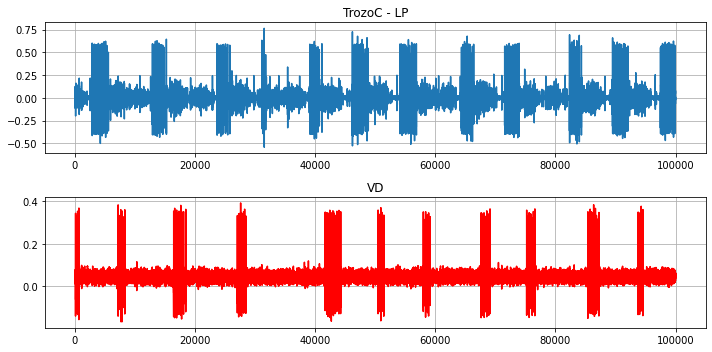

In [ ]:
plotTrozo(trozoC,"TrozoC")

Para discretizar la señal habrá que transformar los eventos que sean spikes, en valores de 1 y los que no sean spikes en 0. Para ello, estableceremos un umbral a partir del cual se podrá considerar un evento como un spike o no. Esto se ha realizado a partir de ensayo y error a través del calculo del percentil de un nivel de confianza alto, ya que solo nos interesa los eventos más significativos de la sección derecha de la distribución.

### Selección umbral

#### LP

In [ ]:
LPThresholdTC = np.percentile(trozoC["LP"],99.4)
LPThresholdTC

0.396729

Con un percel con nivel de confianza del 99.4% se ha obtenido un umbral de 0.4

In [ ]:
def transformData(events: pd.Series,threshold: float):
    return events.apply(lambda x: 1 if x > threshold else 0)

In [ ]:
TrozoCLPTransform= transformData(trozoC["LP"],LPThresholdTC)

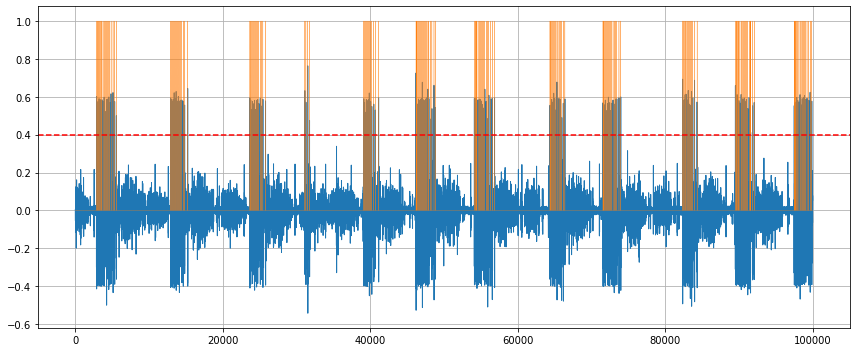

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(range(0,100000),trozoC["LP"][:100000], linewidth=1)
ax.plot(range(0,100000),TrozoCLPTransform[:100000],linewidth=0.3)
ax.axhline(y=LPThresholdTC,c="r",linestyle="--")
plt.tight_layout()
plt.grid()

#### VD

In [ ]:
VDThresholdTC = np.percentile(trozoC["VD"],99.70)

In [ ]:
VDThresholdTC

0.314941

Con un percentil con nivel de confianza del 99.7% se obtiene un umbral de 0.31

In [ ]:
TrozoCVDTransform= transformData(trozoC["VD"],VDThresholdTC)

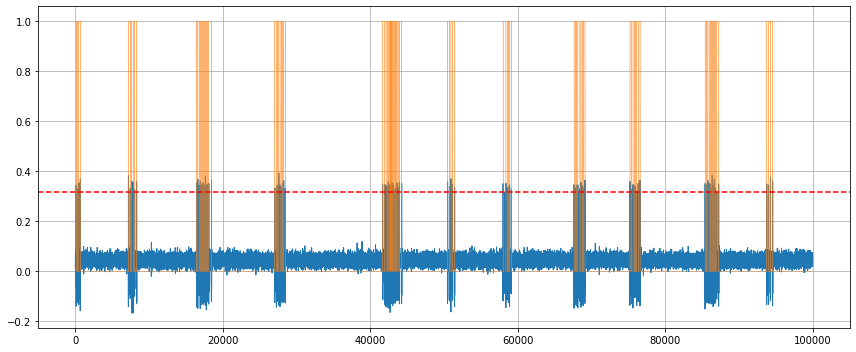

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(range(0,100000),trozoC["VD"][:100000], linewidth=1)
ax.plot(range(0,100000),TrozoCVDTransform[:100000],linewidth=0.3)
ax.axhline(y=VDThresholdTC,c="r",linestyle="--")
plt.tight_layout()
plt.grid()

### Agrupar spikes

Ahora se procederá a agrupar los spikes, ya que un spike se puede prolongar por lo que se encontrará varios 1's consecutivos que realmente contarían como un único spike. Para ello, se sustituye los 1's consecutivos por 0's salvo el valor central que se dejara con el 1.

In [ ]:
spikesLPC = len(TrozoCLPTransform[TrozoCLPTransform == 1])
porcentaje_SpikesLPC = spikesLPC/L_trozoC

spikesVDC = len(TrozoCVDTransform[TrozoCVDTransform == 1])
porcentaje_SpikesVDC = spikesVDC/L_trozoC

print("--------TrozoC---------")
print("LP:")
print("Spikes: "+str(spikesLPC))
print("% Spikes: "+str(porcentaje_SpikesLPC*100))
print("VD:")
print("Spikes: "+str(spikesVDC))
print("% Spikes: "+str(porcentaje_SpikesVDC*100))

--------TrozoC---------
LP:
Spikes: 119080
% Spikes: 0.599968762123571
VD:
Spikes: 59261
% Spikes: 0.29857867662248017


In [ ]:
def groupSpikes(events: pd.Series):
    result = []
    count_ones = 0

    for element in events:
        if element == 1:
            count_ones += 1
        else:
            if count_ones > 1:
                middle = count_ones // 2
                result.extend([0] * (count_ones - middle - 1))
                result.append(1)
                result.extend([0] * middle)
            elif count_ones == 1:
                result.append(1)
            result.append(0)
            count_ones = 0

    if count_ones > 1:
        middle = count_ones // 2
        result.extend([0] * (count_ones - middle - 1))
        result.append(1)
        result.extend([0] * middle)
    elif count_ones == 1:
        result.append(1)

    return np.array(result)

In [ ]:
singlePeaksLPC = groupSpikes(TrozoCLPTransform)
singlePeaksVDC = groupSpikes(TrozoCVDTransform)

In [ ]:
spikesLPCGroup = len(singlePeaksLPC[singlePeaksLPC == 1])
porcentaje_SpikesLPCGroup = spikesLPCGroup/L_trozoC

spikesVDGroup = len(singlePeaksVDC[singlePeaksVDC == 1])
porcentaje_SpikesVDGroup = spikesVDGroup/L_trozoC

print("--------TrozoC---------")
print("LP:")
print("Spikes: "+str(spikesLPCGroup))
print("% Spikes: "+str(porcentaje_SpikesLPCGroup*100))
print("VD:")
print("Spikes: "+str(spikesVDGroup))
print("% Spikes: "+str(porcentaje_SpikesVDGroup*100))
print("\nSe ha reducido la cantidad de spikes en:")
print("LP: "+str(spikesLPC - spikesLPCGroup))
print("VD: "+str(spikesVDC - spikesVDGroup))

--------TrozoC---------
LP:
Spikes: 31086
% Spikes: 0.15662268172130775
VD:
Spikes: 19360
% Spikes: 0.097542788333157

Se ha reducido la cantidad de spikes en:
LP: 87994
VD: 39901


En este gráfico, se puede observar los valores del trocoC, la discreatizada y la gráfica tras la agrupación de los spikes con este marcado. Tanto la discretizada y la agrupación de los spikes ha sido normalizado con el valor máximo del rango dado de los datos originales. Se puede observa claramente las transformaciones y como se comportan.

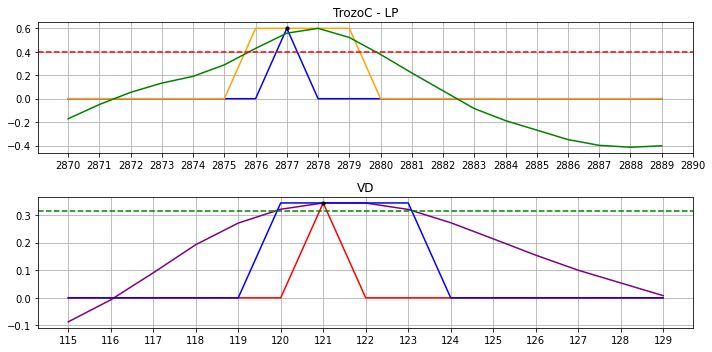

In [ ]:
fig, axs = plt.subplots(figsize=(10, 5),ncols=1,nrows=2)
maxTrozoLPC = trozoC["LP"][2870:2890].max()
maxTrozoVDC = trozoC["VD"][115:130].max()

axs[0].scatter(np.where(singlePeaksLPC[2870:2890] == 1)[0]+2870, singlePeaksLPC[2870:2890][singlePeaksLPC[2870:2890] == 1]*maxTrozoLPC, c="black", marker="o", s=10,zorder=3)
axs[0].plot(range(2870,2890),singlePeaksLPC[2870:2890]*maxTrozoLPC,c="blue")
axs[0].plot(range(2870,2890),TrozoCLPTransform[2870:2890]*maxTrozoLPC,c="orange")
axs[0].plot(range(2870,2890),trozoC["LP"][2870:2890],c="green")
axs[0].axhline(y=LPThresholdTC,c="r",linestyle="--")
axs[0].set_xticks(range(2870, 2891))

axs[1].scatter(np.where(singlePeaksVDC[115:130] == 1)[0]+115, singlePeaksVDC[115:130][singlePeaksVDC[115:130] == 1]*maxTrozoVDC, c="black", marker="o", s=10,zorder=3)
axs[1].plot(range(115,130),trozoC["VD"][115:130],c="purple")
axs[1].plot(range(115,130),singlePeaksVDC[115:130]*maxTrozoVDC,c="r")
axs[1].plot(range(115,130),TrozoCVDTransform[115:130]*maxTrozoVDC,c="blue")
axs[1].axhline(y=VDThresholdTC,c="g",linestyle="--")
axs[1].set_xticks(range(115, 130))

axs[0].grid()
axs[0].set_title("TrozoC - LP")
axs[1].set_title("VD")
plt.tight_layout()
plt.grid()

### Tamaño ventana

Lo siguiente a realizar es elegir un tamaño de ventana que represente el intervalo mínimo de medición. Para ello hay que considerar que por ventana solo puede haber un spike y tiene que ser el mismo tamaño en LP y VD. Para desestimar la idea de utilizar la distancia mínima entre los spikes, calcularemos la distancia entre ellos y se dibujará el histograma.


In [ ]:
def diff_distance(events: np.ndarray):
  peaks = np.where(events==1)
  dists = np.diff(peaks)
  return dists

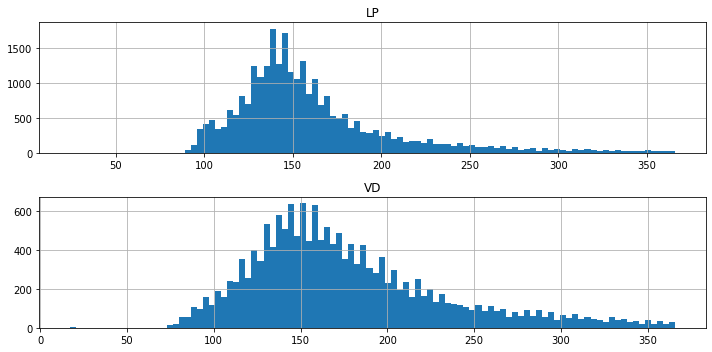

In [ ]:
def histDistancias(singlePeaksLP, singlePeaksVD):
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 5),ncols=1,nrows=2)

    distLP = diff_distance(singlePeaksLP)
    distVD = diff_distance(singlePeaksVD)

    percentile = min(np.percentile(distLP,90),np.percentile(distVD,90))
    ax1.hist(distLP[distLP<percentile],100)
    ax2.hist(distVD[distVD<percentile],100)
    ax1.grid()
    ax1.set_title("LP")
    ax2.set_title("VD")
    plt.tight_layout()
    plt.grid()

histDistancias(singlePeaksLPC,singlePeaksVDC)

Se observa que los spikes con una distancia pequeña como menor de 50, son una pequeñisima parte de los eventos pudiendose considerar eventos atípicos y la mayoría de eventos se encuentran con un rango más amplio por lo que se podría perder información de la relación entre spikes (perder información mutua) con el criterio de escoger la distancia mínima sin ninguna restricción.

In [ ]:
distLPC = diff_distance(singlePeaksLPC)
distVDC = diff_distance(singlePeaksVDC)

percentile = min(np.percentile(distLPC,90),np.percentile(distVDC,90))
np.sort(distLPC[(distLPC<percentile) & (distLPC < 80)])

array([24, 24, 25, 26, 26, 26, 28, 29, 29, 29, 31, 39, 39, 40, 41, 42, 42,
       50, 54, 65], dtype=int64)

In [ ]:
np.sort(distVDC[(distVDC<percentile) & (distVDC < 80)])

array([17, 20, 35, 40, 48, 53, 56, 59, 63, 70, 73, 73, 74, 75, 75, 75, 75,
       76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77,
       77, 78, 78, 78, 78, 79], dtype=int64)

Para solucionar este problema se ha observado que en LP el valor mínimo de distancia entre spikes y que no se consideren valores atípicos es de 75. Por lo que se considera el tamaño de ventana igual a 75.

In [ ]:
def aplicarVentana(serie_tem:pd.Series, tam:int):
  deco_final = []
  sub_series = np.array_split(serie_tem,  tam)
  for window in sub_series:
    if 1 in window:
      deco_final.append(1)
    else:
      deco_final.append(0)

  return np.array(deco_final)

In [ ]:
windowLPC = aplicarVentana(singlePeaksLPC,len(singlePeaksLPC)/75)
windowVDC = aplicarVentana(singlePeaksVDC,len(singlePeaksLPC)/75)

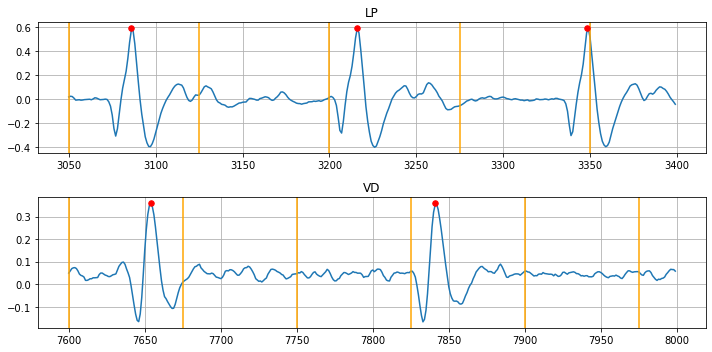

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5),ncols=1,nrows=2)

maxLPC = np.max(trozoC["LP"][3050:3400])
maxVDC = np.max(trozoC["VD"][7600:8000])

ax1.plot(range(3050,3400),trozoC["LP"][3050:3400])
for i in range(3050,3400,75):
    ax1.axvline(i, c='orange')
ax1.scatter(np.where(singlePeaksLPC[3050:3400] == 1)[0]+3050, singlePeaksLPC[3050:3400][singlePeaksLPC[3050:3400] == 1]*maxLPC, c="red", marker="o", s=30,zorder=5)

ax2.plot(range(7600,8000),trozoC["VD"][7600:8000])
for i in range(7600,8000,75):
    ax2.axvline(i, c='orange')
ax2.scatter(np.where(singlePeaksVDC[7600:8000] == 1)[0]+7600, singlePeaksVDC[7600:8000][singlePeaksVDC[7600:8000] == 1]*maxVDC, c="red", marker="o", s=30,zorder=3)
ax1.grid()
ax1.set_title("LP")
ax2.set_title("VD")
plt.tight_layout()
plt.grid()

## Información mutua

Tras obtener la representación de la información sobre los spikes, se quiere calcular la relación entre los spikes, es decir la información mútua(MI). Para ello se utiliza una ventana deslizantes de x bits (1 a 8 bits), la cual tendrá solapamiento, y se obtendra de la secuencia una sería de segmentos o palabras de la que se calculara la probabilidad de ocurrencia. Un ejemplo utilizando una ventana de 4 bits con solapamiento del 50% sería el siguiente:

$$
\text{X} = (0010101) \implies X_{\text{ventana}} = \Bigg[ (0010)(1010)\dots \dots\Bigg]
$$

Para calcular la Información Mútua(MI) se calculara a partir de la entropía donde:

$$MI(X,Y)=H(X)+H(Y)-H(X, Y)\ donde\ la\ H\ representa\ la\ entropia,$$
$$H(X)=-\sum_{x}p(x)\log_2(p(x))\quad \text{y} \quad H(X,Y)=-\sum_{xy}p(x,y)\log_2(p(x,y)).$$


Para calcular la transferencia de información que tenemos entre las dos series, de LP a VD y de VD a LP, se utilizará la siguiente fórmula:
$$
E_{XY} = \frac{MI(X,Y)}{H(Y)}.
$$

Este valor oscila en $[0,1]$, pues $H(S)$ representa la cantidad máxima de información que se puede transmitir del estímulo a la respuesta.

Por último, se utilizaran diferentes tamaños de ventana para ver como se ve afectado el MI respecto a los tamaños de palabra. Para ello se usará una función que calcula la información mutua normalizada dado un tamaño de ventana. Esta viene dada por la siguiente formula:
$$
\hat I(X,Y) = \frac{I(X,Y)}{window\_size *n\_bits}
$$

In [ ]:
# Creación de la función de entropía para una serie de datos y con posibilidad de diferentes panatllas
def entropy(data, tamPalabra=[1]):

  entropias = np.empty(len(tamPalabra))
  for j,tamaño in enumerate(tamPalabra):
    #Crear las diferentes ventanas generando estados
    ventanas = np.array([data[:,i:i+tamaño] for i in range(data.shape[1]-tamaño)])
    #Probabilidades de los estados
    _, frec = np.unique(ventanas,axis=0,return_counts=True)
    prob=frec/np.sum(frec)
    #Entropia
    entropias[j]=-np.sum(prob * np.log2(prob))

  return entropias

In [ ]:
def informacion_mutua(data, tamPalabra):
    H_X = entropy(data[0].reshape(1,-1),tamPalabra)
    H_Y = entropy(data[1].reshape(1,-1),tamPalabra)
    H_XY = entropy(data,tamPalabra)
    MI = H_X + H_Y - H_XY
    return MI,H_X,H_Y

In [ ]:
def transferenciaInfo(data, tamPalabra, verbose=True):
    MI,H_X,H_Y = informacion_mutua(data, tamPalabra)
    E_XY = MI/H_X
    E_YX = MI/H_Y

    if verbose==1:
        for tam,Mi,Hx,Hy,Exy,Eyx in zip(tamPalabra,MI,H_X,H_Y,E_XY,E_YX):
            print("Datos")
            print("Tamaño palabra: "+str(tam))
            print("Informacion mutua: "+str(Mi))
            print("Entropia(LP): "+str(Hx))
            print("Entropia(VD): "+str(Hy))
            print("Transferencia de informacion de LP a VD: "+str(Exy))
            print("Transferencia de informacion de VD a LP: "+str(Eyx))

    return MI, H_X, H_Y, E_XY, E_YX

In [ ]:
tamVent = np.arange(1,9,1)
windowTrozoC = np.array([windowLPC,windowVDC])
MI,H_X,H_Y,E_XY,E_YX = transferenciaInfo(windowTrozoC,tamVent)
H_XY = H_X + H_Y - MI

Datos
Tamaño palabra: 1
Informacion mutua: 0.011526061278091082
Entropia(LP): 0.5218831271117844
Entropia(VD): 0.3775419945393755
Transferencia de informacion de LP a VD: 0.022085521986270815
Transferencia de informacion de VD a LP: 0.0305292164707494
Datos
Tamaño palabra: 2
Informacion mutua: 0.04653584376488351
Entropia(LP): 1.0437467064254942
Entropia(VD): 0.7546210250184859
Transferencia de informacion de LP a VD: 0.04458538022529835
Transferencia de informacion de VD a LP: 0.061667833550945024
Datos
Tamaño palabra: 3
Informacion mutua: 0.06985095477140213
Entropia(LP): 1.4112724461150006
Entropia(VD): 1.0559155621280236
Transferencia de informacion de LP a VD: 0.04949501775060531
Transferencia de informacion de VD a LP: 0.06615202699601193
Datos
Tamaño palabra: 4
Informacion mutua: 0.08382274396222167
Entropia(LP): 1.7238322839292115
Entropia(VD): 1.3027681853150432
Transferencia de informacion de LP a VD: 0.04862581165446129
Transferencia de informacion de VD a LP: 0.064342025624

### TrozoC - Resultados según tamaño de palabra (bits)

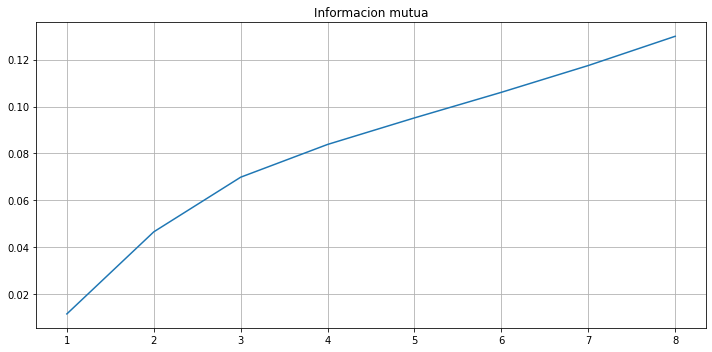

In [ ]:
def infoMutuaWindow(tam,mi):
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(tam,mi)
    ax.set_title("Informacion mutua")
    plt.tight_layout()
    plt.grid()

infoMutuaWindow(tamVent,MI)

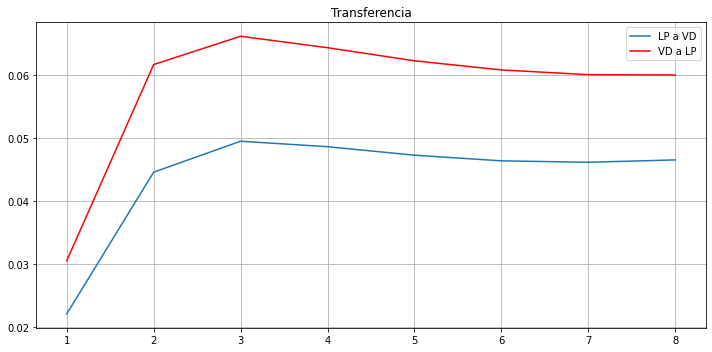

In [ ]:
def transferenciaWindow(tam, exy,eyx):
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(tam,exy,label="LP a VD")
    ax.plot(tam,eyx,c="red",label="VD a LP")
    ax.set_title("Transferencia")
    ax.legend()
    plt.tight_layout()
    plt.grid()
transferenciaWindow(tamVent, E_XY, E_YX)

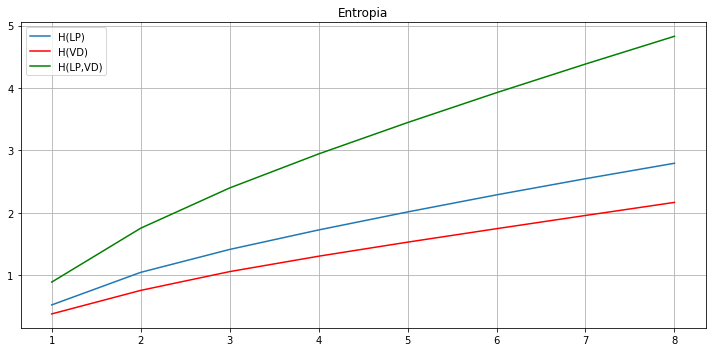

In [ ]:
def entropiasWindow(tam, hx, hy, hxy):
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(tam,hx,label="H(LP)")
    ax.plot(tam,hy,c="red",label="H(VD)")
    ax.plot(tam,hxy,c="green",label="H(LP,VD)")
    ax.set_title("Entropia")
    ax.legend()
    plt.tight_layout()
    plt.grid()
entropiasWindow(tamVent, H_X, H_Y, H_XY)

Ahora se realizará un análisis de los resultado respecto al tamaño de palabra:
 - Información mútua: Se observa un crecimiento continuo con el aumento del número de bits de palabra entre 1 y 8 bits, pero a partir del tamaño 3 (b=3) se produce un pequeño decrecimiento en la velocidad de crecimiento. Esto se produce igual con la entropía.

 - Transferencia de información: Se observa que $E_{LP->VD}$ queda con cualquier tamaño de palabra un poco por debajo que $E_{VD->LP}$. Ambas comparten que aumenta su valor continuamente hasta el tamaño 3, produciendose un decrecimiento de velocidad entre el tamaño 2 y 3. A partir del tamaño 3 decrece su valor. Esto significa que ambos tiene como punto de máxima tranferencia de información en el tamaño de palabra 3, habiendo mayor transferencia de VD a LP y siendo valores muy pequeños significa que no tienen una relación clara o fuerte entre LP y VD, esto también se puede deber a otros aspectos como a la presencia de ruido.

 - También se observa que los valores de la entropia crecen mucho más que la información mútua, esto indica que el sistema experimenta una mayor independencia lo cual puede provocar problemas de sincronización o corroborando su falta de correlación.

## Probando diferentes tamaños de bin

Se probara desde 75 hasta 2500 de 25 en 25 para comprobar como se ve afectando la información mútua y la transferencia de información para diferentes tamaños de ventana.

In [ ]:
def infoDiffBin(tamañoBin):
    tamVent = np.arange(1,9,1)

    MIs =[]
    E_XY = []
    E_YX = []

    for i in tamañoBin:
        LP = aplicarVentana(singlePeaksLPC,L_trozoC/i)
        VD = aplicarVentana(singlePeaksVDC,L_trozoC/i)

        trozoWindow = np.array([LP,VD])

        Mi,_,_,Exy,Eyx =transferenciaInfo(trozoWindow,tamVent,verbose=False)

        MIs.append(Mi)
        E_XY.append(Exy)
        E_YX.append(Eyx)

    return MIs,E_XY,E_YX

In [ ]:
tamBin = np.arange(5,600,40)
MIs, E_XYs, E_YXs = infoDiffBin(tamBin)

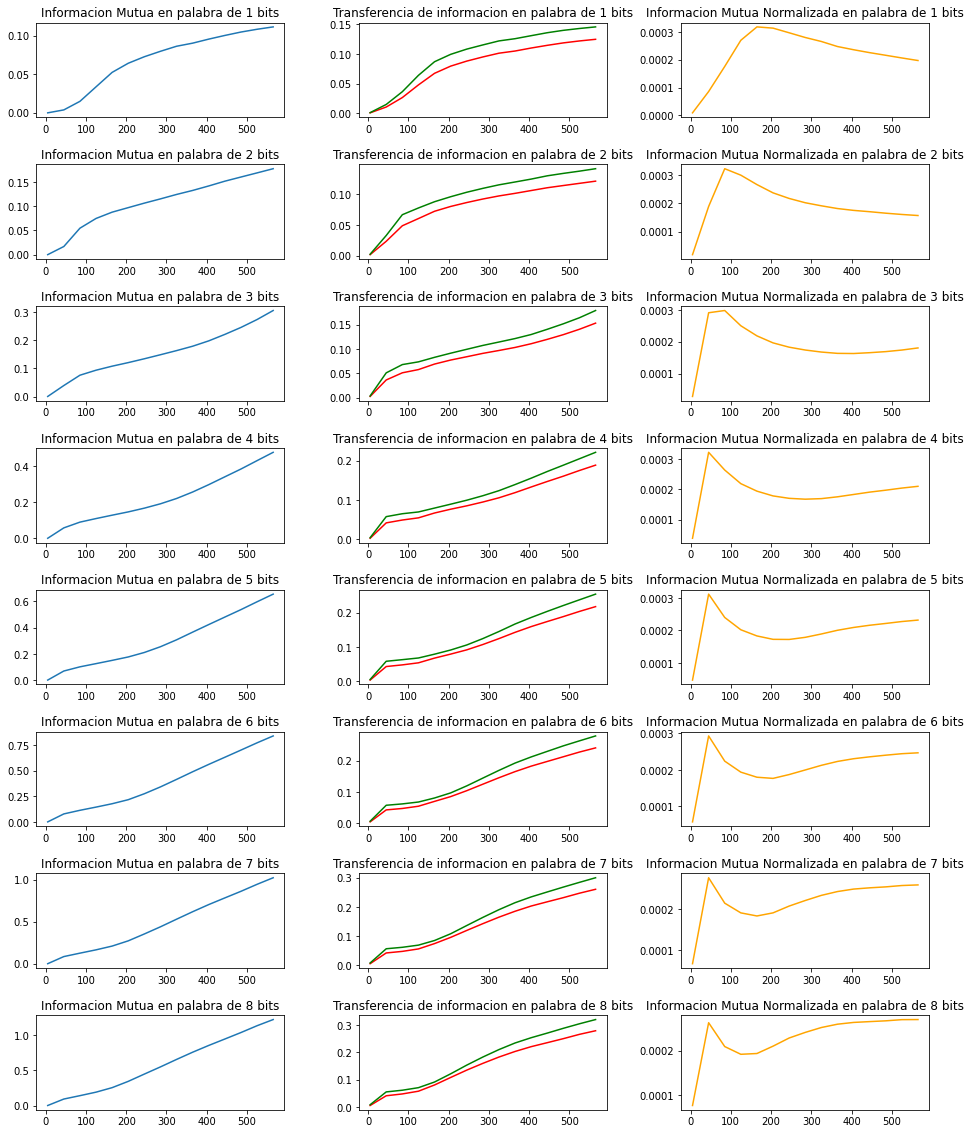

In [ ]:
def plotDifBin(MIS,EXYS,EYXS,tamañoBin):
    fig, axs = plt.subplots(figsize=(16, 20),nrows=8,ncols=3)
    plt.subplots_adjust(hspace=0.5,wspace=0.3)
    for i in tamVent:
        mi=[]
        exy=[]
        eyx=[]
        min=[]
        for j in range(len(tamañoBin)):
            mi.append(MIS[j][i-1])
            exy.append(EXYS[j][i-1])
            eyx.append(EYXS[j][i-1])
            min.append(mi[j]/(tamañoBin[j]*i))

        axs[i-1,0].set_title("Informacion Mutua en palabra de "+str(i)+" bits")
        axs[i-1,1].set_title("Transferencia de informacion en palabra de "+str(i)+" bits")
        axs[i-1,2].set_title("Informacion Mutua Normalizada en palabra de "+str(i)+" bits")

        axs[i-1,0].plot(tamañoBin,mi)
        axs[i-1,1].plot(tamañoBin,exy,c="red",label="LP a VD")
        axs[i-1,1].plot(tamañoBin,eyx,c="green",label="VD a LP")
        axs[i-1,2].plot(tamañoBin,min,c="orange")


plotDifBin(MIs,E_XYs,E_YXs,tamBin)

Vemos que el comportamiento de la información mútua en función de la ventana crece mientras el tamaño de bin aumente, esto es debido a que la probalidad de encontrar un evento en el sistema es mayor (encontrar estados 11 por ejemplo). Ocurre lo mismo con la transferencia de información. La IM y la transferencia en ambos sentidos maxima se encuentra en el mayor tamaño de palabra y de bin, con un valor mayor a 1.2

En cuento a la inofrmación mútua aumenta hasta llegar a cierto punto, a partir de este punto decrece hasta llegar un momento en el que se estabiliza. Este fenómeno llamado saturación se produce al aumentar el tamaño de palabra y de ventana, el denominador, hace que encontrar eventos sea menos significativa. Al buscar patrones más largos por el aumento de ventana, hace que que sea más probable encontrarlos lo que disminuye la sorpresa y por tanto la IM normalizada. Se observa que a partir del tamaño de palabra 4, se produce esta saturación en torno al valor 50.

## Trozo G

Ahora se va a analizar el trozoG, que es el que tiene la información con la inyección de GABA. La columna de tiempo de inyección de GABA se eliminará ya que no es útil para el análisis que se quiere realizar

In [ ]:
trozoG = read_files("TrozoG.txt")
L_trozoG = len(trozoG["LP"])

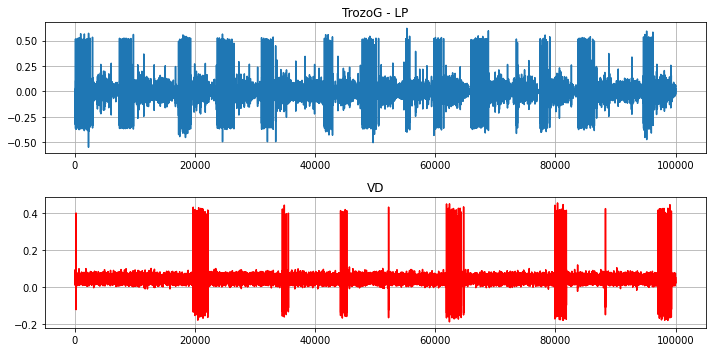

In [ ]:
plotTrozo(trozoG,"TrozoG")

In [ ]:
LPThresholdTG = np.percentile(trozoG["LP"],99.5)
VDThresholdTG = np.percentile(trozoG["VD"],99.4)

TrozoGLPTransform= transformData(trozoG["LP"],LPThresholdTG)
TrozoGVDTransform= transformData(trozoG["VD"],VDThresholdTG)

Para el umbral de LP se ha utilizado un percentil con nivel de confianza del 99.5% con valor de 0.43 y el de VD con 99.4% el valor de 0.25

In [ ]:
spikesLPG = len(TrozoGLPTransform[TrozoGLPTransform == 1])
porcentaje_SpikesLPG = spikesLPG/L_trozoG

spikesVDG = len(TrozoGVDTransform[TrozoGVDTransform == 1])
porcentaje_SpikesVDG = spikesVDG/L_trozoG

print("--------TrozoG---------")
print("LP:")
print("Spikes: "+str(spikesLPG))
print("% Spikes: "+str(porcentaje_SpikesLPG*100))
print("VD:")
print("Spikes: "+str(spikesVDG))
print("% Spikes: "+str(porcentaje_SpikesVDG*100))

--------TrozoG---------
LP:
Spikes: 81788
% Spikes: 0.49919433593749996
VD:
Spikes: 98295
% Spikes: 0.599945068359375


In [ ]:
singlePeaksLPG = groupSpikes(TrozoGLPTransform)
singlePeaksVDG = groupSpikes(TrozoGVDTransform)

In [ ]:
spikesLPGGroup = len(singlePeaksLPG[singlePeaksLPG == 1])
porcentaje_SpikesLPGGroup = spikesLPGGroup/L_trozoG

spikesVDGGroup = len(singlePeaksVDG[singlePeaksVDG == 1])
porcentaje_SpikesVDGGroup = spikesVDGGroup/L_trozoG

print("--------TrozoG---------")
print("LP:")
print("Spikes: "+str(spikesLPGGroup))
print("% Spikes: "+str(porcentaje_SpikesLPGGroup*100))
print("VD:")
print("Spikes: "+str(spikesVDGGroup))
print("% Spikes: "+str(porcentaje_SpikesVDGGroup*100))
print("\nSe ha reducido la cantidad de spikes en:")
print("LP: "+str(spikesLPG - spikesLPGGroup))
print("VD: "+str(spikesVDG - spikesVDGGroup))

--------TrozoG---------
LP:
Spikes: 26048
% Spikes: 0.15898437499999998
VD:
Spikes: 15655
% Spikes: 0.095550537109375

Se ha reducido la cantidad de spikes en:
LP: 55740
VD: 82640


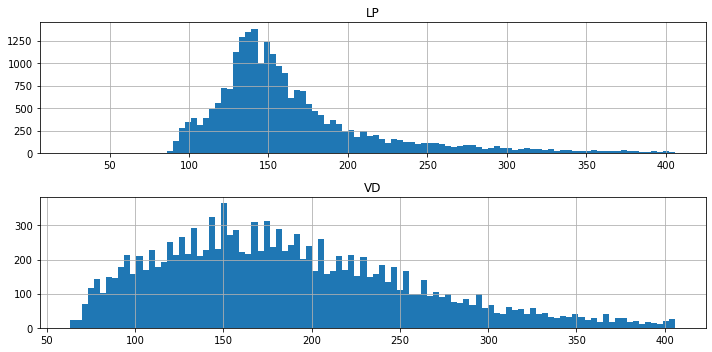

In [ ]:
histDistancias(singlePeaksLPG,singlePeaksVDG)

In [ ]:
distLPG = diff_distance(singlePeaksLPG)
distVDG = diff_distance(singlePeaksVDG)

percentileG = min(np.percentile(distLPG,90),np.percentile(distVDG,90))
np.sort(distLPG[(distLPG<percentileG) & (distLPG>80) &(distLPG < 89)])

array([85, 85, 86, 86, 87, 87, 87, 87, 88, 88, 88, 88, 88], dtype=int64)

In [ ]:
np.sort(distVDG[(distVDG<percentileG) & (distVDG>60) &(distVDG < 67)])

array([63, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66,
       66, 66, 66, 66, 66], dtype=int64)

In [ ]:
windowLPG = aplicarVentana(singlePeaksLPG,len(singlePeaksLPG)/87)
windowVDG = aplicarVentana(singlePeaksVDG,len(singlePeaksLPG)/87)

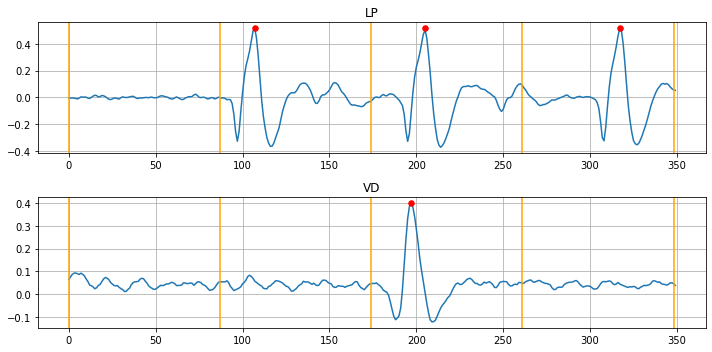

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5),ncols=1,nrows=2)

maxLPG = np.max(trozoG["LP"][0:350])
maxVDG = np.max(trozoG["VD"][0:350])

ax1.plot(range(0,350),trozoG["LP"][0:350])
for i in range(0,350,87):
    ax1.axvline(i, c='orange')
ax1.scatter(np.where(singlePeaksLPG[0:350] == 1)[0], singlePeaksLPG[0:350][singlePeaksLPG[0:350] == 1]*maxLPG, c="red", marker="o", s=30,zorder=5)

ax2.plot(range(0,350),trozoG["VD"][0:350])
for i in range(0,350,87):
    ax2.axvline(i, c='orange')
ax2.scatter(np.where(singlePeaksVDG[0:350] == 1)[0], singlePeaksVDG[0:350][singlePeaksVDG[0:350] == 1]*maxVDG, c="red", marker="o", s=30,zorder=3)
ax1.grid()
ax1.set_title("LP")
ax2.set_title("VD")
plt.tight_layout()
plt.grid()

In [ ]:
windowTrozoG = np.array([windowLPG,windowVDG])
GMI,GH_X,GH_Y,GE_XY,GE_YX = transferenciaInfo(windowTrozoG,tamVent)
GH_XY = GH_X + GH_Y - GMI

Datos
Tamaño palabra: 1
Informacion mutua: 0.014709461605353025
Entropia(LP): 0.5798021423602708
Entropia(VD): 0.4119710448972392
Transferencia de informacion de LP a VD: 0.025369795195087478
Transferencia de informacion de VD a LP: 0.035705086043175946
Datos
Tamaño palabra: 2
Informacion mutua: 0.05082229163889784
Entropia(LP): 1.1473579456968348
Entropia(VD): 0.8135580623903618
Transferencia de informacion de LP a VD: 0.044295062259782844
Transferencia de informacion de VD a LP: 0.062469163527891225
Datos
Tamaño palabra: 3
Informacion mutua: 0.07245852399171149
Entropia(LP): 1.5400230754784696
Entropia(VD): 1.1365101570670713
Transferencia de informacion de LP a VD: 0.04705028459992351
Transferencia de informacion de VD a LP: 0.06375528062036963
Datos
Tamaño palabra: 4
Informacion mutua: 0.08583311540656124
Entropia(LP): 1.8898400749859192
Entropia(VD): 1.3915465000286207
Transferencia de informacion de LP a VD: 0.04541818990011669
Transferencia de informacion de VD a LP: 0.061681816

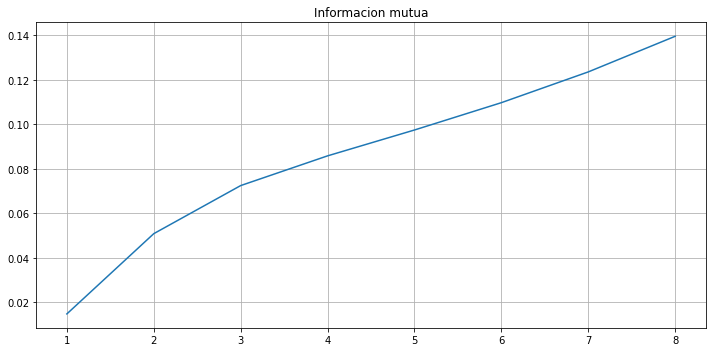

In [ ]:
infoMutuaWindow(tamVent,GMI)

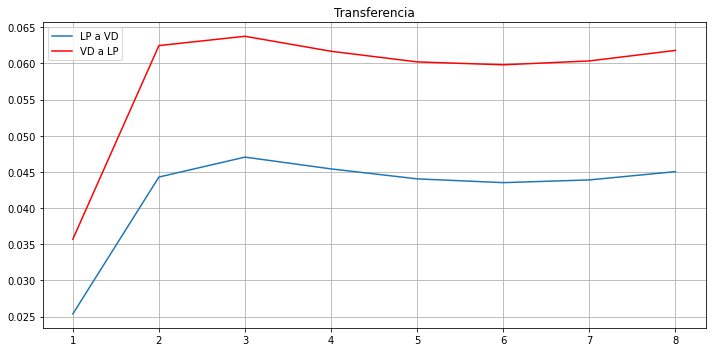

In [ ]:
transferenciaWindow(tamVent, GE_XY, GE_YX)

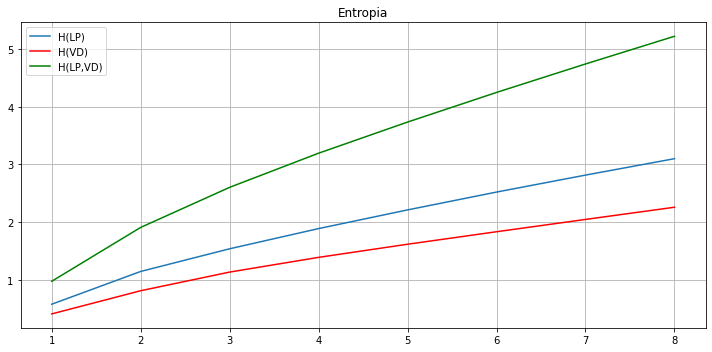

In [ ]:
entropiasWindow(tamVent, GH_X, GH_Y, GH_XY)

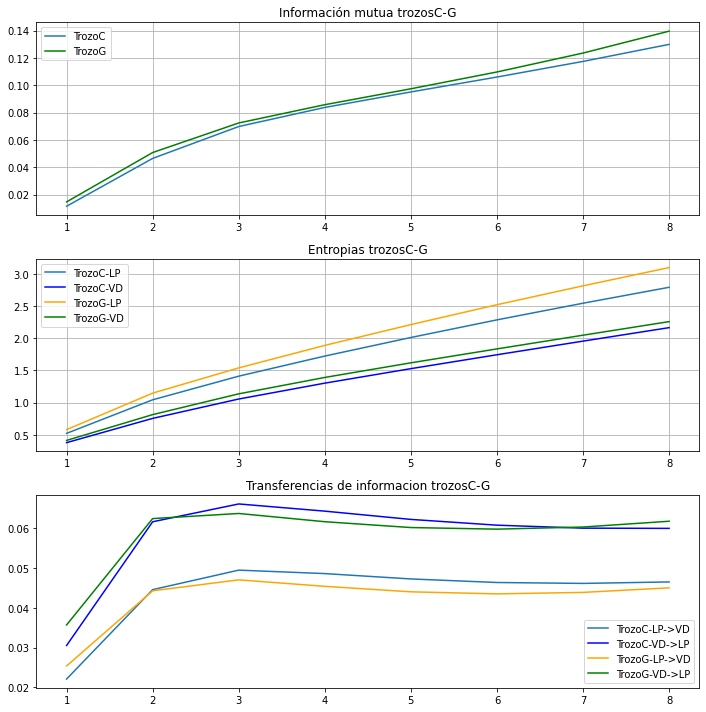

In [ ]:
fig, axs = plt.subplots(figsize=(10, 10),nrows=3)

axs[0].plot(tamVent,MI,label="TrozoC")
axs[0].plot(tamVent,GMI,c="green",label="TrozoG")
axs[0].set_title("Información mutua trozosC-G")
axs[0].legend()
axs[0].grid()

axs[1].plot(tamVent,H_X,label="TrozoC-LP")
axs[1].plot(tamVent,H_Y,c="blue",label="TrozoC-VD")
axs[1].plot(tamVent,GH_X,c="orange",label="TrozoG-LP")
axs[1].plot(tamVent,GH_Y,c="green",label="TrozoG-VD")
axs[1].set_title("Entropias trozosC-G")
axs[1].legend()
axs[1].grid()

axs[2].plot(tamVent,E_XY,label="TrozoC-LP->VD")
axs[2].plot(tamVent,E_YX,c="blue",label="TrozoC-VD->LP")
axs[2].plot(tamVent,GE_XY,c="orange",label="TrozoG-LP->VD")
axs[2].plot(tamVent,GE_YX,c="green",label="TrozoG-VD->LP")
axs[2].set_title("Transferencias de informacion trozosC-G")
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.grid()

Se observas que los valores del trozoG tienden a una forma muy parecida que a los del trozoC, pero se encuentra un ligero decremento en todos sus valores respecto al trozoC, esto puede ser debido a que la inyección de GABA puede producir efectos inhibidores. Se muestra que sigue siendo mayor la transferencia de $E_{VD->LP}$

In [ ]:
GMIs, GE_XYs, GE_YXs = infoDiffBin(tamBin)

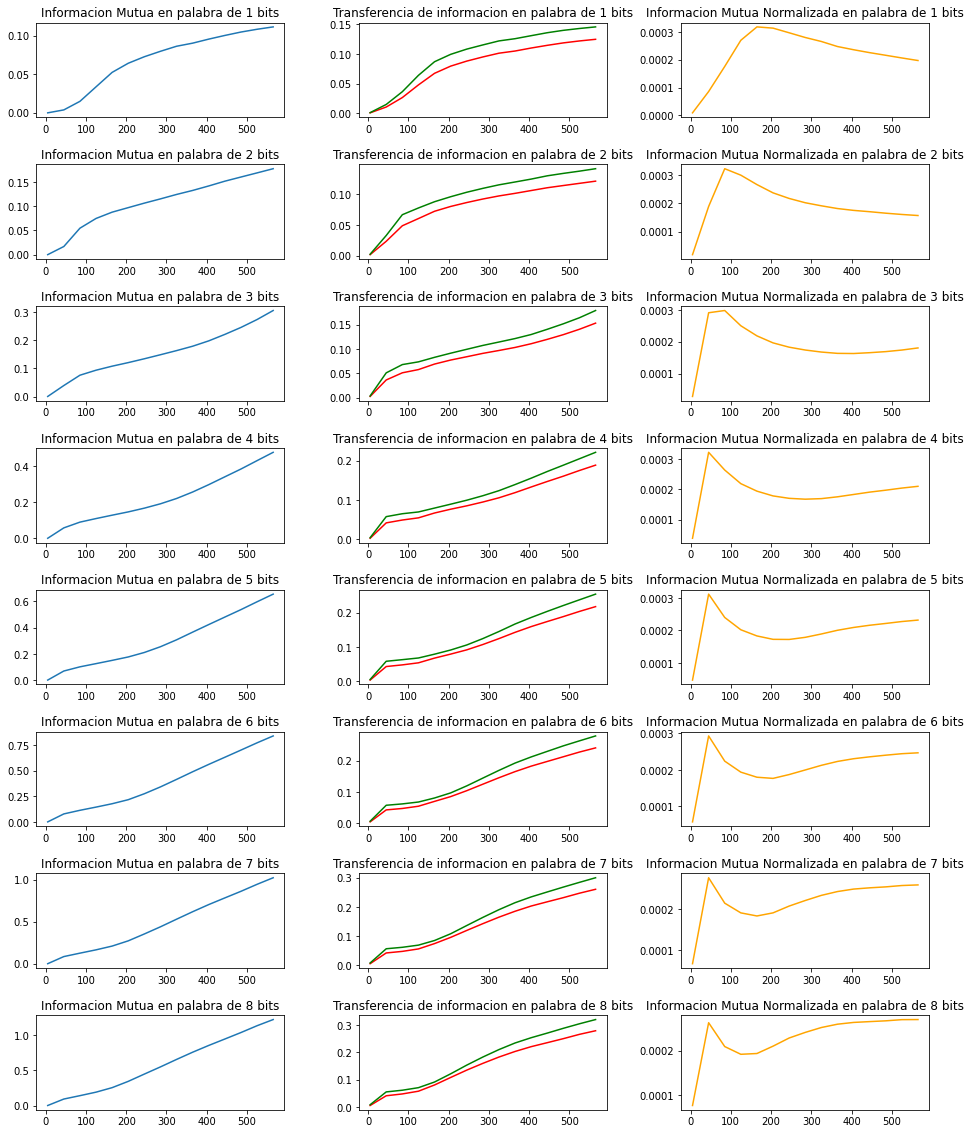

In [ ]:
plotDifBin(GMIs,GE_XYs,GE_YXs,tamBin)

## Trozo R

Por último se hara el trozoR, es el correspomdiemte a la recuperación.

In [ ]:
trozoR = read_files("TrozoR.txt")
L_trozoR = len(trozoR["LP"])

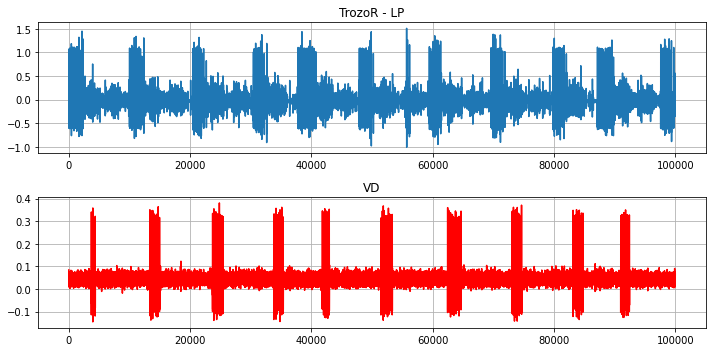

In [ ]:
plotTrozo(trozoR,"TrozoR")

In [ ]:
LPThresholdTR = np.percentile(trozoR["LP"],99.4)
VDThresholdTR = np.percentile(trozoR["VD"],99.40)

TrozoRLPTransform= transformData(trozoR["LP"],LPThresholdTR)
TrozoRVDTransform= transformData(trozoR["VD"],VDThresholdTR)

In [ ]:
spikesLPR = len(TrozoRLPTransform[TrozoRLPTransform == 1])
porcentaje_SpikesLPR = spikesLPR/L_trozoR

spikesVDR = len(TrozoRVDTransform[TrozoRVDTransform == 1])
porcentaje_SpikesVDR = spikesVDR/L_trozoR

print("--------TrozoR---------")
print("LP:")
print("Spikes: "+str(spikesLPR))
print("% Spikes: "+str(porcentaje_SpikesLPR*100))
print("VD:")
print("Spikes: "+str(spikesVDR))
print("% Spikes: "+str(porcentaje_SpikesVDR*100))

--------TrozoR---------
LP:
Spikes: 98228
% Spikes: 0.5995361328125
VD:
Spikes: 98156
% Spikes: 0.5990966796875


In [ ]:
singlePeaksLPR = groupSpikes(TrozoRLPTransform)
singlePeaksVDR = groupSpikes(TrozoRVDTransform)

In [ ]:
spikesLPRGroup = len(singlePeaksLPR[singlePeaksLPR == 1])
porcentaje_SpikesLPRGroup = spikesLPRGroup/L_trozoR

spikesVDRGroup = len(singlePeaksVDR[singlePeaksVDR == 1])
porcentaje_SpikesVDRGroup = spikesVDRGroup/L_trozoR

print("--------TrozoR---------")
print("LP:")
print("Spikes: "+str(spikesLPRGroup))
print("% Spikes: "+str(porcentaje_SpikesLPRGroup*100))
print("VD:")
print("Spikes: "+str(spikesVDRGroup))
print("% Spikes: "+str(porcentaje_SpikesVDRGroup*100))
print("\nSe ha reducido la cantidad de spikes en:")
print("LP: "+str(spikesLPR - spikesLPRGroup))
print("VD: "+str(spikesVDR - spikesVDRGroup))

--------TrozoR---------
LP:
Spikes: 23400
% Spikes: 0.142822265625
VD:
Spikes: 18451
% Spikes: 0.11261596679687501

Se ha reducido la cantidad de spikes en:
LP: 74828
VD: 79705


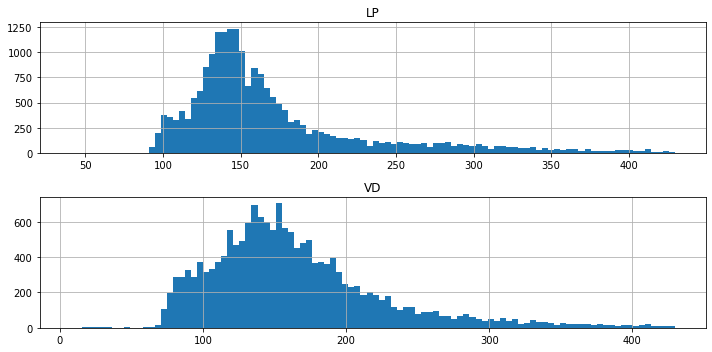

In [ ]:
histDistancias(singlePeaksLPR,singlePeaksVDR)

In [ ]:
distLPR = diff_distance(singlePeaksLPR)
distVDR = diff_distance(singlePeaksVDR)

percentileR = min(np.percentile(distLPR,90),np.percentile(distVDR,90))
np.sort(distLPR[(distLPR<percentileR) & (distLPR>88) &(distLPR < 94)])

array([89, 89, 90, 90, 90, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92,
       92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93,
       93, 93, 93, 93, 93, 93, 93, 93], dtype=int64)

In [ ]:
np.sort(distVDR[(distVDR<percentileR) & (distVDR > 60) & (distVDR < 70)])

array([61, 61, 63, 64, 67, 68, 68, 68, 68, 69, 69, 69], dtype=int64)

En el trozoR se ha observado que en VD el valor mínimo de distancia entre spikes y que no se consideren valores atípicos es de 68. Por lo que se considera el tamaño de ventana igual a 68.

In [ ]:
windowLPR = aplicarVentana(singlePeaksLPR,len(singlePeaksLPR)/68)
windowVDR = aplicarVentana(singlePeaksVDR,len(singlePeaksLPR)/68)

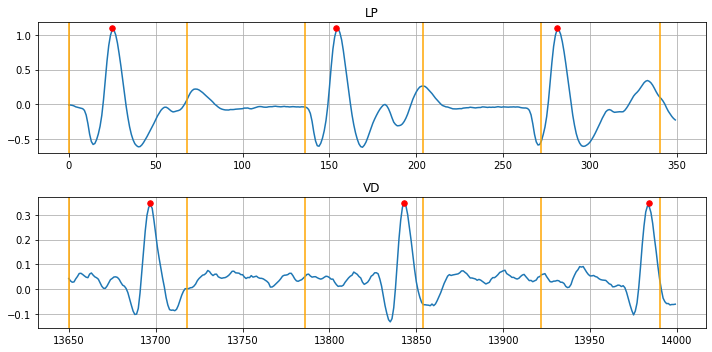

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5),ncols=1,nrows=2)

maxLPR = np.max(trozoR["LP"][0:350])
maxVDR = np.max(trozoR["VD"][13650:14000])

ax1.plot(range(0,350),trozoR["LP"][0:350])
for i in range(0,350,68):
    ax1.axvline(i, c='orange')
ax1.scatter(np.where(singlePeaksLPR[0:350] == 1)[0], singlePeaksLPR[0:350][singlePeaksLPR[0:350] == 1]*maxLPR, c="red", marker="o", s=30,zorder=5)

ax2.plot(range(13650,14000),trozoR["VD"][13650:14000])
for i in range(13650,14000,68):
    ax2.axvline(i, c='orange')
ax2.scatter(np.where(singlePeaksVDR[13650:14000] == 1)[0]+13650, singlePeaksVDR[13650:14000][singlePeaksVDR[13650:14000] == 1]*maxVDR, c="red", marker="o", s=30,zorder=3)
ax1.grid()
ax1.set_title("LP")
ax2.set_title("VD")
plt.tight_layout()
plt.grid()

In [ ]:
windowTrozoR = np.array([windowLPR,windowVDR])
RMI,RH_X,RH_Y,RE_XY,RE_YX = transferenciaInfo(windowTrozoR,tamVent)
RH_XY = RH_X + RH_Y - RMI

Datos
Tamaño palabra: 1
Informacion mutua: 0.009802577738630136
Entropia(LP): 0.4597845647721598
Entropia(VD): 0.3898456767679543
Transferencia de informacion de LP a VD: 0.021319936530465468
Transferencia de informacion de VD a LP: 0.025144764512714787
Datos
Tamaño palabra: 2
Informacion mutua: 0.04015540481879509
Entropia(LP): 0.9178127168514355
Entropia(VD): 0.7781424594863009
Transferencia de informacion de LP a VD: 0.04375119681992265
Transferencia de informacion de VD a LP: 0.051604181637002706
Datos
Tamaño palabra: 3
Informacion mutua: 0.064208791040135
Entropia(LP): 1.2807622046512257
Entropia(VD): 1.0925231430170441
Transferencia de informacion de LP a VD: 0.05013326502527469
Transferencia de informacion de VD a LP: 0.05877110379814928
Datos
Tamaño palabra: 4
Informacion mutua: 0.07837335910282706
Entropia(LP): 1.5880702809075973
Entropia(VD): 1.334547686993709
Transferencia de informacion de LP a VD: 0.04935131652865888
Transferencia de informacion de VD a LP: 0.0587265332416

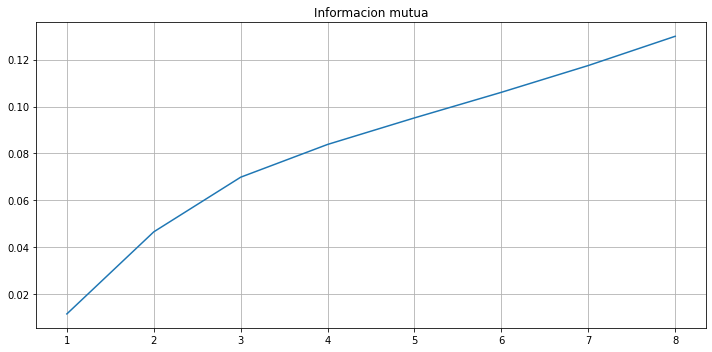

In [ ]:
infoMutuaWindow(tamVent,MI)

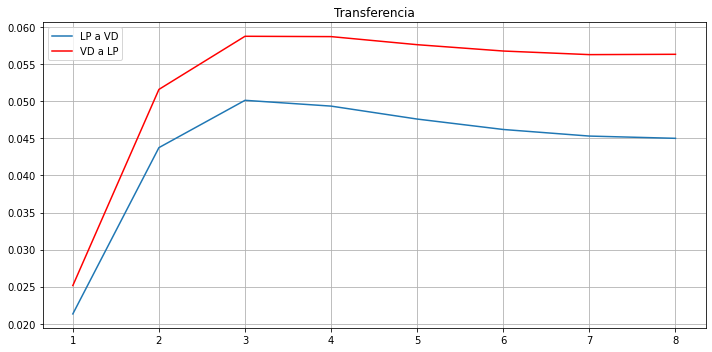

In [ ]:
transferenciaWindow(tamVent, RE_XY, RE_YX)

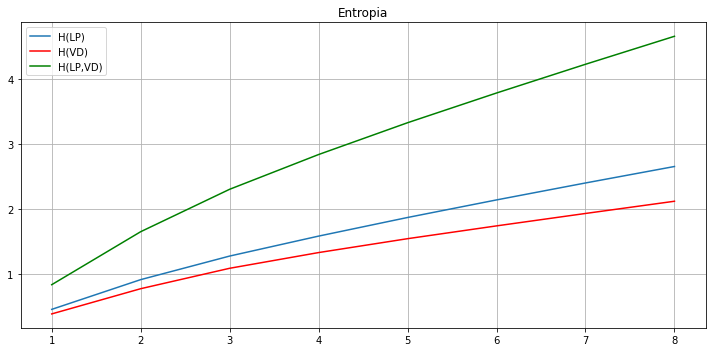

In [ ]:
entropiasWindow(tamVent, RH_X, RH_Y, RH_XY)

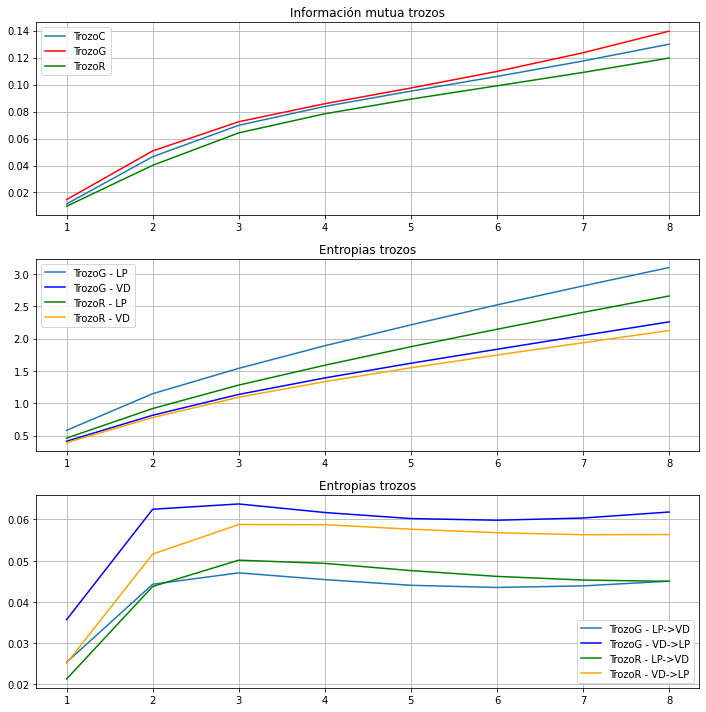

In [ ]:
fig, axs = plt.subplots(figsize=(10, 10),nrows=3)

axs[0].plot(tamVent,MI,label="TrozoC")
axs[0].plot(tamVent,GMI,c="red",label="TrozoG")
axs[0].plot(tamVent,RMI,c="green",label="TrozoR")
axs[0].set_title("Información mutua trozos")
axs[0].legend()
axs[0].grid()

axs[1].plot(tamVent,GH_X,label="TrozoG - LP")
axs[1].plot(tamVent,GH_Y,c="blue",label="TrozoG - VD")
axs[1].plot(tamVent,RH_X,c="green",label="TrozoR - LP")
axs[1].plot(tamVent,RH_Y,c="orange",label="TrozoR - VD")
axs[1].set_title("Entropias trozos")
axs[1].legend()
axs[1].grid()

axs[2].plot(tamVent,GE_XY,label="TrozoG - LP->VD")
axs[2].plot(tamVent,GE_YX,c="blue",label="TrozoG - VD->LP")
axs[2].plot(tamVent,RE_XY,c="green",label="TrozoR - LP->VD")
axs[2].plot(tamVent,RE_YX,c="orange",label="TrozoR - VD->LP")
axs[2].set_title("Entropias trozos")
axs[2].legend()
axs[2].grid()

plt.tight_layout()

En el trozoR se llegan a los valores más bajos puede ser debido a la racuperación tras la inyección de GABA. En este caso sigue siendo $E_{VD->LP}$ mayor que $E_{LP->VD}$.

In [ ]:
RMIs, RE_XYs, RE_YXs = infoDiffBin(tamBin)

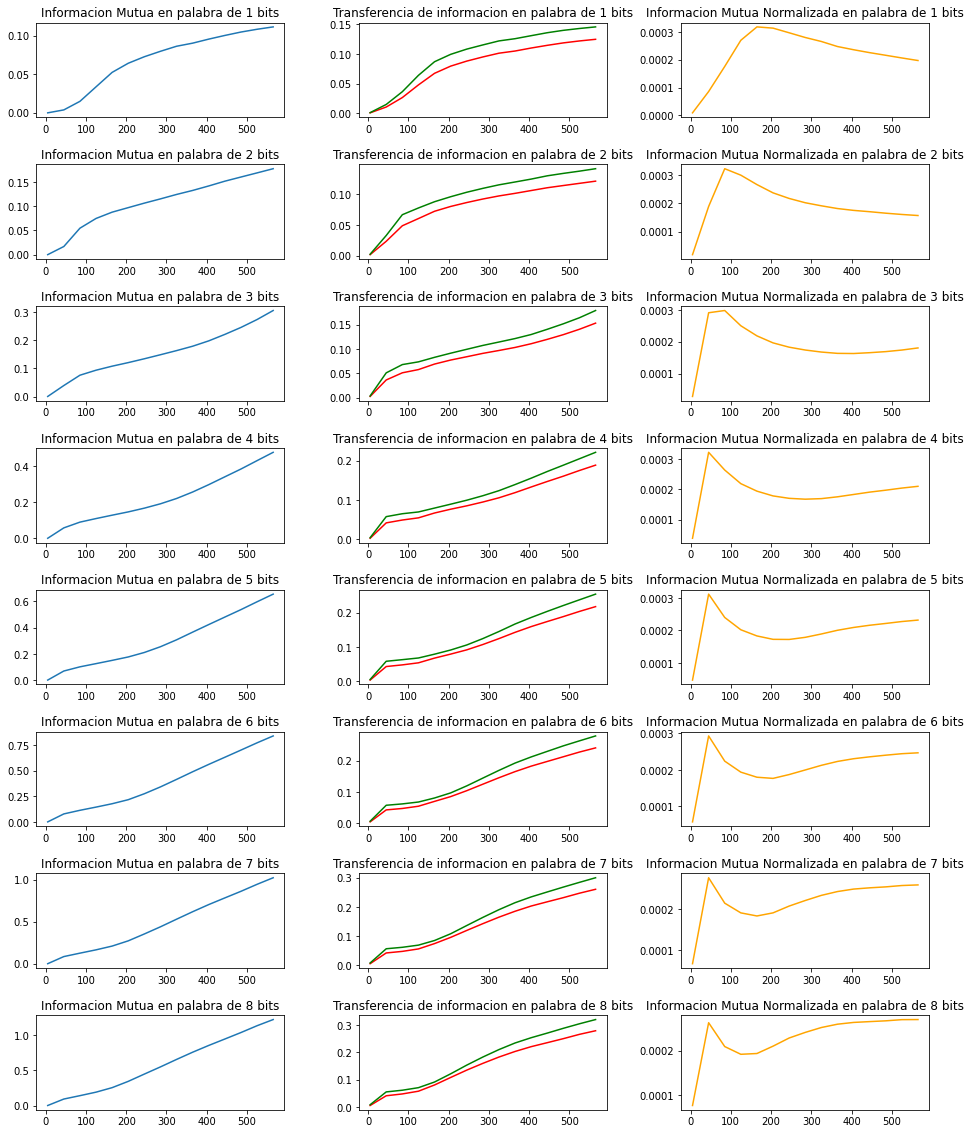

In [ ]:
plotDifBin(RMIs,RE_XYs,RE_YXs,tamBin)

#Codificación SAX

Ahora vamos a introducir una nueva diferente de rpresentar las series temporales basandonos en el artículo [A Symbolic Representation of Time Series, with Implications for
Streaming Algorithms](link:https://www.cs.ucr.edu/~eamonn/SAX.pdf)

La técnica es **SAX**, siglas de Symbolic Aggregate approXimation. Lo que hace es reducir un vector de $\mathbb{R}^n$ reducirlo a otro de $\mathbb{R}^w$ con $w<<n$. El algoritmo utiliza de base la salida proporcionada por el algoritmo **PAA**, el cual se expica más adelante.

Ahora vamos a definir ciertos términos:
* $S$ será la serie temporal con $S=s_1,...,s_n$.
* $\bar{S}$ será la serie temporal con $\bar{S}=\bar{s_1},...,\bar{s_w}$ con el uso de **PAA**
* $\hat{S}$ representación simbólica de la serie temporal con $\hat{S}=\hat{s_1},...,\hat{s_w}$.
* $w$ representa el número de segmentos en los que **PA** representa la serie.
* $a$ será el número de los posibles valores que tome $\bar{S}$.

## PAA

Siglas de *Pairwise Aggregate Approximation*, realiza una estandarización de una serie para que tenga $\mu=0$ y $\sigma^2=1$. Esto se hace para comparar series con diferentes amplitudes.

Para cada elemento de la serie $\bar{S}$ se hace la siguiente operación:
$$
\bar{c_i}=\frac{w}{n}\sum^{\frac{n}{w}i}_{j=\frac{n}{w}(i-1)+1}c_j
$$

Aunque pueda asustar la fórmula anterior, consiste en reducir la serie de $n$ a $w$ dimensiones. El valor de cada valor $w_i$ es la media de valores que hay en una ventana, siendo el tamaño fijo, usada para dividir el espacio.

## Discretización

Ahora que tenemos $\bar{S}$, haremos una técnica de discretización que produzca símbolos de forma equiprobable. Esto se consigue dado que las series temporales normalizadas siguen una distribución gaussiana.
De esta forma podemos fijar una serie de **puntos** que produciran áreas del mismo tamaño (pongamos $a$) bajo la curva. Se definen estos **puntos** como una lista ordenada $P=ρ_1,...\rho_{a-1}$ de tal forma que el área bajo la Gaussiana sigue una sitribución $\mathcal{N}(0,1)$.Se puede usar para ello los cuartiles de la distribución.

Una vez que se ha seleccionado el número de particiones a realizar y obtenidos los **puntos**, convertiremos la secuencia *PAA* en una secuencia de símbolos. Supongamos que vamos a dividir el conjunto usando $k\in\mathbb{N}$ *puntos*.Obtendremos la serie $\hat{S}=\hat{s_1},...,\hat{s_w}$ del siguiente modo:


1.   Vamos a considerar $\alpha_1=a$ y $\alpha_j$ la j-ésima letra del abecedario.
2.   Con nuestra serie $\bar{S}$ vamos a convertirla en $\hat{S}$ convirtiendo cada elemento con la siguiente condición:
$$
\hat{c_i}=\alpha_j\ \Leftrightarrow \rho_{j-1}≤\bar{c_i}\rho_j
$$

## Implementación

Para implementar el algoritmo de creación de representaciones de las series temporales, los parámetros a tener en cuenta son:
* $w$ qu es el número de ventanas en el que vamos a dividir la serie temporal inicial.
* $a$ el número de *puntos* o trozos con la misma área bajo la Gaussiana a una $\mathcal{N}(0,1)$. Lo que viene a ser el número de letras del abecedario a utilizar.

In [ ]:
def paa(serie, tam_window=70):
  return np.array([np.mean(serie[i:i+tam_window])
          for i in range (0,len(serie), tam_window)])

In [ ]:
def paa2sax(serie_paa, percentile):
  return [ascii_lowercase[np.sum(percentile < x)] for x in serie_paa]

In [ ]:
def letter2number(arr):
    result = np.array([np.array([ord(c) - 97 for c in row]) for row in arr])
    return result

In [ ]:
def SAXify(df, n_windows=None, n_letters=3):
    """
      Función que se encarga de hacer la codificación SAX a una serie temporal.
    """
    cols_result = []

    window_size = 70 if n_windows is None else ceil(df.shape[0]/n_windows)

    # Obtain N(0,1) quantiles
    percentiles = [ norm.ppf(k/n_letters) for k in range(1, n_letters)]

    for col in range(len(df.columns)):
        vec = np.array(df.iloc[:,col]).reshape(-1,1)

        # Normalize the values
        vec_standarized = StandardScaler().fit_transform(vec)

        # Obtain the PAA representation
        vec_paa = paa(vec_standarized, window_size)

        # Obtain SAX representation
        result = paa2sax(vec_paa, percentiles)

        #Update vector in df
        cols_result.append(result)

    return np.array(cols_result)

In [ ]:
def get_SAX_estimator(df, n_windows=None, n_letters=3, word_sizes=np.arange(1,9,1)):
    trozo_SAX = SAXify(df, n_windows=n_windows, n_letters=n_letters)
    trozo_SAX_numbers = letter2number(trozo_SAX)

    return informacion_mutua(trozo_SAX_numbers, word_sizes), word_sizes

## SAX con TrozoC

Vamos a ver qué resultados obtenemos al pasar TrozoC por la codificación SAX.

In [ ]:
estimador_C = get_SAX_estimator(trozoC)

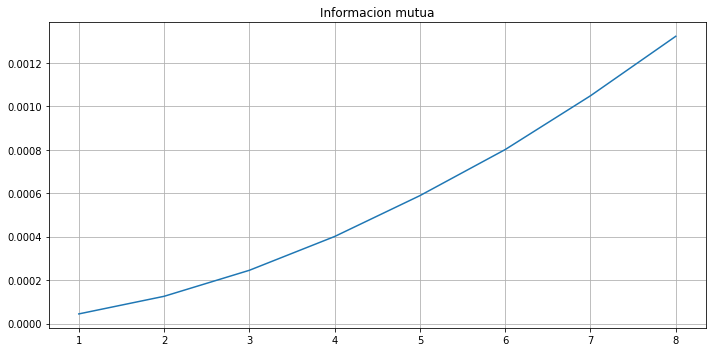

In [ ]:
infoMutuaWindow(estimador_C[1], estimador_C[0][0])

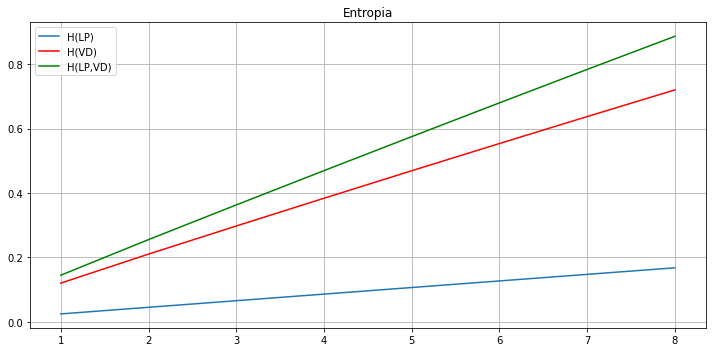

In [ ]:
h_x = estimador_C[0][1]
h_y = estimador_C[0][2]
h_xy = h_x + h_y - estimador_C[0][0]
entropiasWindow(estimador_C[1], h_x, h_y, h_xy)

Ahora vamos a ver lo que ocurre cuando usamos dos símbolos con la codificación SAX.

In [ ]:
estimador_C2 = get_SAX_estimator(trozoC,n_letters=2)

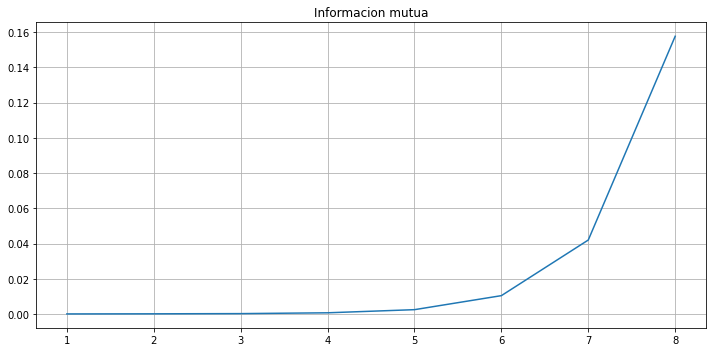

In [ ]:
infoMutuaWindow(estimador_C2[1], estimador_C2[0][0])

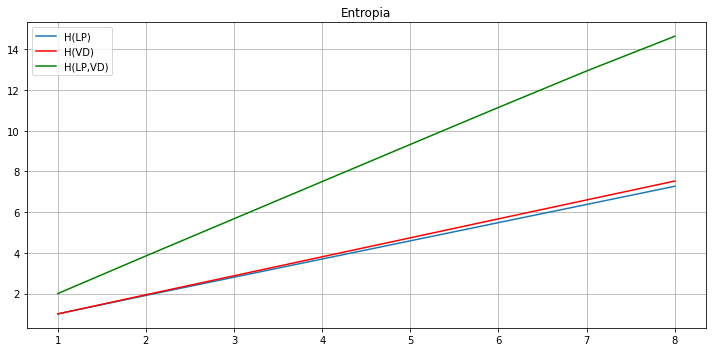

In [ ]:
h_x = estimador_C2[0][1]
h_y = estimador_C2[0][2]
h_xy = h_x + h_y - estimador_C2[0][0]
entropiasWindow(estimador_C2[1], h_x, h_y, h_xy)

De estos resultados se puede observa los siguientes:
El comportamiento de la información mutua es diferente a la representación realizada anteriormente. En general el crecimiento con un tamaño de palabra menor es mucho más lenta. En el caso de utilizar 3 símbolos, esta diferencia se ve de forma más drástica a partir del tamaño 5 de palabra. En cuanto los valores, con 2 símbolos los valores son muy bajos ya que la cantidad de información compartida es muy baja y en el caso de 3 símbolos es mucho mayor ya que es posible capturar una mayor variedad de relaciones y dependencias.

En el aspecto de la entropía, el comportamiento también cambia. En cuanto los valores, se observa una gran diferencia y más dependiendo de su representación. En el caso de 2 símbolos la entropía es mucho más baja debido también al uso de la representación SAX, ya que simplifica su representación y reduce su incertidumbre. Pero con 3 símbolos aumenta su valor de forma considerada, esto puede ser debido a que hay una mayor diversidad en la representación ya que se divide en tres categorías. Y las dos comparten un comportamiento de crecimiento más constante.


## SAX con TrozoG

A continuación vamos a comprobar los resultados que se obtienen con el segundo trozo que corresponde a la inyección de GABA.

In [ ]:
estimador_G = get_SAX_estimator(trozoG)

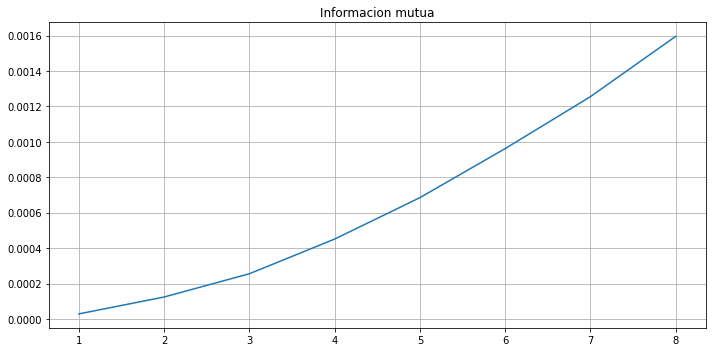

In [ ]:
infoMutuaWindow(estimador_G[1], estimador_G[0][0])

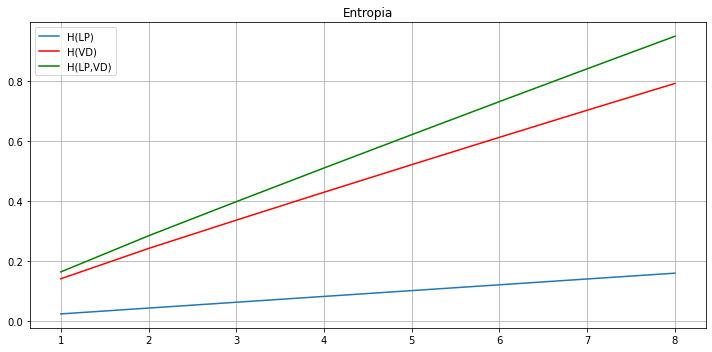

In [ ]:
h_x = estimador_G[0][1]
h_y = estimador_G[0][2]
h_xy = h_x + h_y - estimador_G[0][0]
entropiasWindow(estimador_G[1], h_x, h_y, h_xy)

Comprobamos los resultados que se obtienen con el uso de dos símbolos.

In [ ]:
estimador_G2 = get_SAX_estimator(trozoG,n_letters=2)

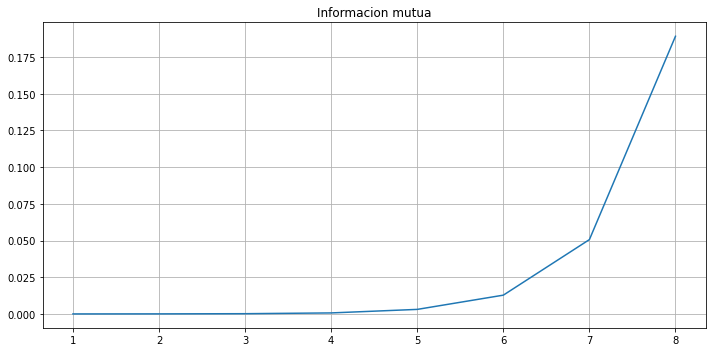

In [ ]:
infoMutuaWindow(estimador_G2[1], estimador_G2[0][0])

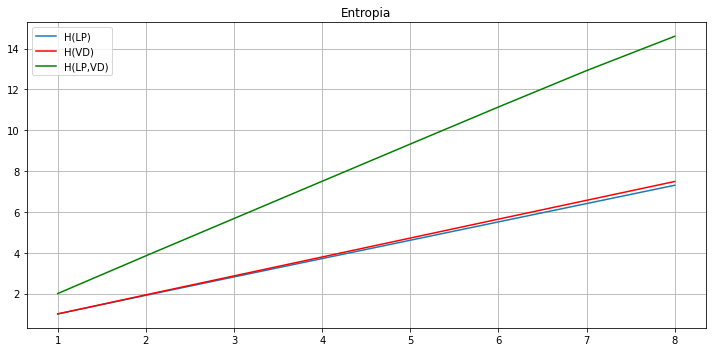

In [ ]:
h_x = estimador_G2[0][1]
h_y = estimador_G2[0][2]
h_xy = h_x + h_y - estimador_G2[0][0]
entropiasWindow(estimador_G2[1], h_x, h_y, h_xy)

Se tiene un comportamiento parecido al del anterior trozo

## SAX con TrozoR

Por último, vamos a comprobar los resultados que se obtienen al usar la codificación SAX con el último trozo correspondiente a la recuperación del sistema.

In [ ]:
estimador_R = get_SAX_estimator(trozoR)

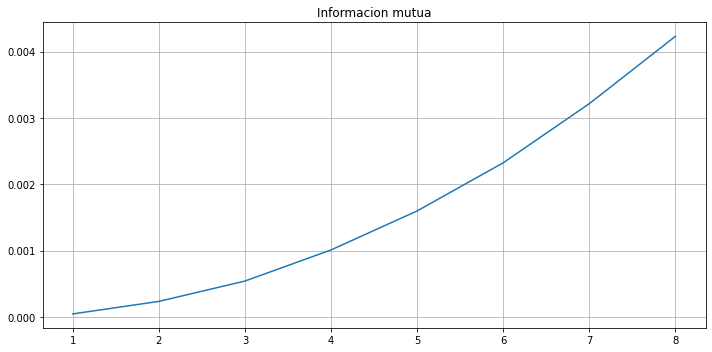

In [ ]:
infoMutuaWindow(estimador_R[1], estimador_R[0][0])

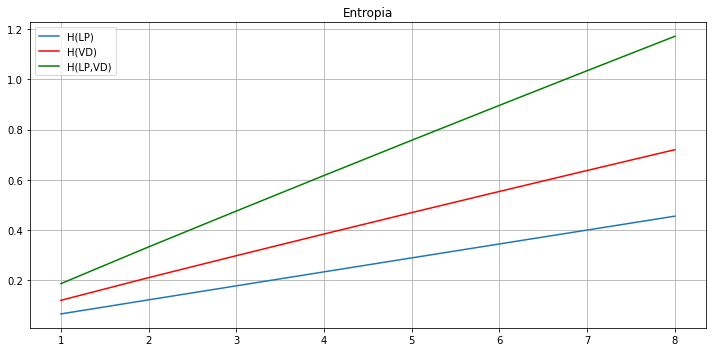

In [ ]:
h_x = estimador_R[0][1]
h_y = estimador_R[0][2]
h_xy = h_x + h_y - estimador_R[0][0]
entropiasWindow(estimador_R[1], h_x, h_y, h_xy)

Ahora vamos a ver qué resultados obtenemos al usar 2 símbolos

In [ ]:
estimador_R2 = get_SAX_estimator(trozoR,n_letters=2)

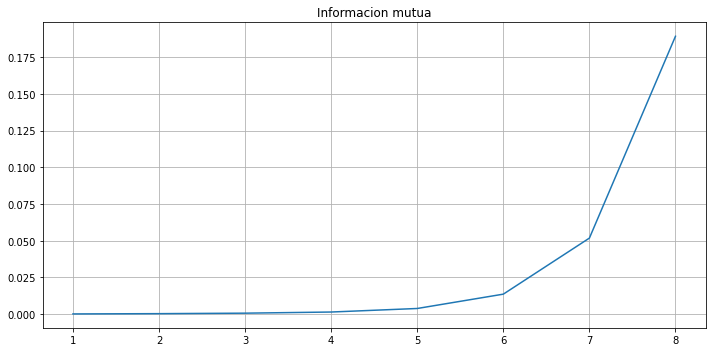

In [ ]:
infoMutuaWindow(estimador_R2[1], estimador_R2[0][0])

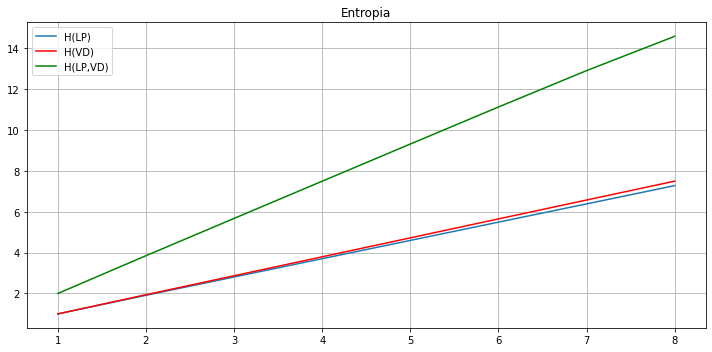

In [ ]:
h_x = estimador_R2[0][1]
h_y = estimador_R2[0][2]
h_xy = h_x + h_y - estimador_R2[0][0]
entropiasWindow(estimador_R2[1], h_x, h_y, h_xy)

El camportamiento es practicamente igual al del resto de trozos.

# Conclusiones

Tras la realización del estudio de un problema real, se va a expresar diferentes conclusiones a las que se ha llegado con este trabajo.
- Se ha experimentado la importancia de realizar un buen procesamiento y representación de los datos, ya que esto afecta consideradamente al análisis de los diferentes resultados como la entropía, la información mutua, etc. Para diferentes trozos se han utilizados diferentes percentiles para obtener un umbral lo más correcto posible y luego se ha realizado una discretización de los datos y la agrupación de los spikes.
- Se ha estudiado como se ven afectado las neuronas LP y VD en diferentes estados (control, GABA y recuperación). Como se mantiene un comportamiento parecido, como la transferencia de información es mayor de VD a LP y como se va decrementando sus valores sobre todo en el estado de recuperación.
- Se ha demostrado como se varía la información mutua, las transferencias de información y la información mtua normalizada probando con los diferentes tamaños de palabra (1 a 8 bits) y de ventana (valores entre 5 y 600 saltando en 40 en 40)
- Se ha demostrado que con la codificación SAX los resultados tienen mucha varianza en los valores de *información mutua* y las entropías de las neuronas *LP* y *VD*.
- En la representación SAX, se ha observado que el cambio del número de símbolos puede tener una gran impacto en el cambio de sus valores tanto en la entropía como en la información mutua.